# Spec2Vec - Find similar compounds for unknown substances
One very important use case for a spectral similariy measure is libarary matching.  
This means matching previously unseen/unknown spectra to known, annotated sepctra in a larger library.
With spec2vec, however, it also becomes possible to search large datasets only based on Spec2Vec similarities. This allows to also find suggestions for compounds which are not in the library.

In [1]:
import os
import sys
import gensim
import numpy as np
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA\\matchms\\data\\'
sys.path.insert(0, ROOT)

### Import pre-processed dataset "AllPositive"

In [2]:
from matchms.importing import load_from_json

filename = os.path.join(path_data,'gnps_positive_ionmode_cleaned_by_matchms_and_lookups.json')
spectrums = load_from_json(filename)

print("number of spectra:", len(spectrums))

number of spectra: 112956


### Post-process data

In [3]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

def post_process_s2v(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
        
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

# apply post processing steps to the data
spectrums_s2v = [post_process_s2v(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_s2v = [s for s in spectrums_s2v if s is not None]

In [4]:
len(spectrums_s2v)

95320

## Inspect annotations

In [5]:
Inchikeys = []
for spec in spectrums_s2v:
    Inchikeys.append(spec.get("inchikey"))

In [6]:
Inchikeys[:20]

['IYDKWWDUBYWQGF-NNAZGLEUSA-N',
 'KNGPFNUOXXLKCN-ZNCJFREWSA-N',
 'WXDBUBIFYCCNLE-NSCMQRKRSA-N',
 'CGZKSPLDUIRCIO-RPCRKUJJSA-N',
 '',
 'USXIYWCPCGVOKF-LERJCCFDSA-N',
 '',
 'WCNJVJCYRBJSLC-BCJYPDSRSA-N',
 'USXIYWCPCGVOKF-NOENWEJRSA-N',
 'WCNJVJCYRBJSLC-BCJYPDSRSA-N',
 '',
 'USXIYWCPCGVOKF-NOENWEJRSA-N',
 'NAIKIJSSBJHCBL-VIPNTUGYSA-N',
 '',
 '',
 'GWGKNTICBPKKKW-LBBUGJAGSA-N',
 'NAIKIJSSBJHCBL-IPUGVWFUSA-N',
 'NAIKIJSSBJHCBL-IPUGVWFUSA-N',
 'GWGKNTICBPKKKW-LBBUGJAGSA-N',
 'KZVHAGNFWJIOMX-YIEYWENTSA-N']

In [218]:
import pandas as pd

#inchikeys_pd = pd.Series([x for x in Inchikeys if x])
inchikeys_pd = pd.Series([x for x in Inchikeys])
inchikeys_pd.str[:14].value_counts()[:10]

                  18226
NEGQHKSYEYVFTD      432
SULIDBRAXVDKBU      426
IQGPMZRCLCCXAG      308
WTJKGGKOPKCXLL      295
IIZPXYDJLKNOIY      235
RWKUXQNLWDTSLO      234
QIBZFHLFHCIUOT      225
ZAYXPDDGEIJGGW      212
QJWDAOSZZYVBJZ      210
dtype: int64

In [212]:
len(inchikeys_pd), len(spectrums_s2v)

(95320, 95320)

In [219]:
inchikeys_pd.isna().values

array([False, False, False, ..., False, False, False])

In [230]:
inchikeys_notempty = inchikeys_pd[[i for i,x in enumerate(inchikeys_pd) if x]]
inchikeys_notempty.head()

0    IYDKWWDUBYWQGF-NNAZGLEUSA-N
1    KNGPFNUOXXLKCN-ZNCJFREWSA-N
2    WXDBUBIFYCCNLE-NSCMQRKRSA-N
3    CGZKSPLDUIRCIO-RPCRKUJJSA-N
5    USXIYWCPCGVOKF-LERJCCFDSA-N
dtype: object

In [220]:
inchikeys_pd[not inchikeys_pd.isna().values].head()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Text(0, 0.5, 'Number of inchikeys with respective number of occurences')

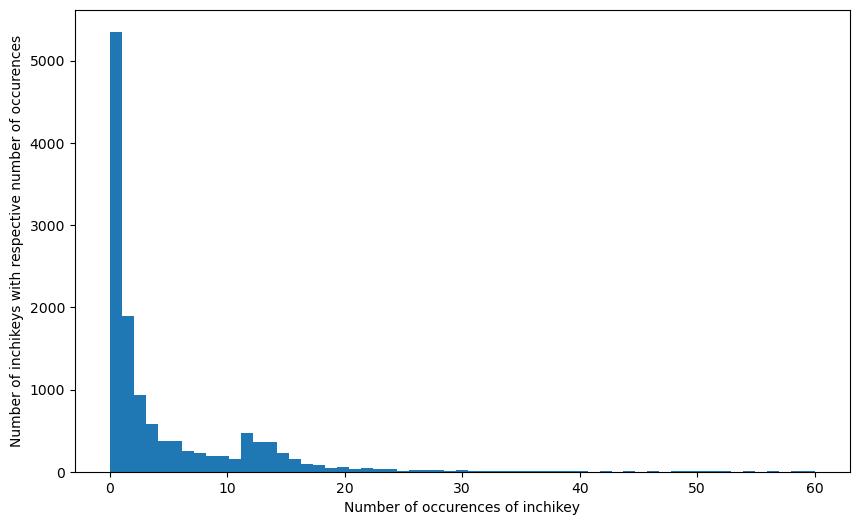

In [231]:
plt.figure(figsize=(10,6))
plt.hist(inchikeys_notempty.str[:14].value_counts(), np.linspace(0, 60, 60))
plt.xlabel('Number of occurences of inchikey')
plt.ylabel('Number of inchikeys with respective number of occurences')

In [232]:
suitable_inchikeys = pd.DataFrame(inchikeys_notempty.str[:14].value_counts()[inchikeys_notempty.str[:14].value_counts().values >= 5])
suitable_inchikeys.reset_index(level=suitable_inchikeys.index.names, inplace=True)
suitable_inchikeys.columns = (['inchikey14', 'occurences'])

# Important: sort values to make it reproducible (same occurences have random order otherwise!)
suitable_inchikeys = suitable_inchikeys.sort_values(['occurences', 'inchikey14'], ascending=False)
suitable_inchikeys.head(15)

,inchikey14,occurences
0,NEGQHKSYEYVFTD,432
1,SULIDBRAXVDKBU,426
2,IQGPMZRCLCCXAG,308
3,WTJKGGKOPKCXLL,295
4,IIZPXYDJLKNOIY,235
5,RWKUXQNLWDTSLO,234
6,QIBZFHLFHCIUOT,225
7,ZAYXPDDGEIJGGW,212
8,QJWDAOSZZYVBJZ,210
9,KILNVBDSWZSGLL,205


### Randomly select 200 inchikeys

In [233]:
unique_inchikeys = inchikeys_notempty.str[:14].unique()
unique_inchikeys.shape

(12846,)

In [234]:
num_inchikeys = 200

np.random.seed(0) # to make it reproducible
selected_inchikeys = np.random.choice(unique_inchikeys, num_inchikeys, replace=False)
selected_inchikeys[:25]

array(['USEXQPWLCGBYNT', 'URAYPUMNDPQOKB', 'OGNSCSPNOLGXSM',
       'GNPWSZMDKPTDLE', 'VYFYYTLLBUKUHU', 'WDKPRHOCWKLQPK',
       'DMJNNHOOLUXYBV', 'CXOXHMZGEKVPMT', 'HTCVSLIHSFBUEL',
       'ROWKODQLOIEBHL', 'RJECHNNFRHZQKU', 'XIYSEKITPHTMJT',
       'ZDYHKOFGYRLNSW', 'GKHCBYYBLTXYEV', 'QPNFBUARICHXGG',
       'BECNNJLLIXQSGY', 'NOHZAMDNJBVHTA', 'DVLLGHPCJPEUHA',
       'CLNILJPYOXIKRO', 'BGLMHEUNVVQFLX', 'HBUBKKRHXORPQB',
       'UTZJMFNIKVHUDP', 'BWHHTYGQTQWLHV', 'MNKNQKOOKLVXDB',
       'DEJPAJWPCTUPPL'], dtype=object)

In [235]:
selected_spectra = []

for inchikey in selected_inchikeys:
    matches = inchikeys_notempty[inchikeys_notempty.str[:14] == inchikey].index.values
    selected_spectra.extend(matches)

print(len(selected_spectra), "spectra were found with inchikeys from selected_inchikeys list.")

1030 spectra were found with inchikeys from selected_inchikeys list.


In [236]:
len(inchikeys_pd), len(inchikeys_notempty), len(spectrums_s2v)

(95320, 77092, 95320)

In [244]:
ID = 0
inchikey = selected_inchikeys[0]
print(inchikey)

matches_test = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values

for idx in matches_test:
    print(spectrums_s2v[idx].get("inchikey")[:14])

USEXQPWLCGBYNT
USEXQPWLCGBYNT
USEXQPWLCGBYNT


In [245]:
print(selected_spectra[:25])

[66105, 95146, 18446, 63328, 63329, 63330, 94926, 3117, 18524, 24773, 25253, 25709, 63340, 63341, 63342, 63343, 63344, 63731, 63732, 63733, 63734, 63735, 64942, 64943, 67682]


Text(0, 0.5, 'Number of inchikeys with respective number of occurences')

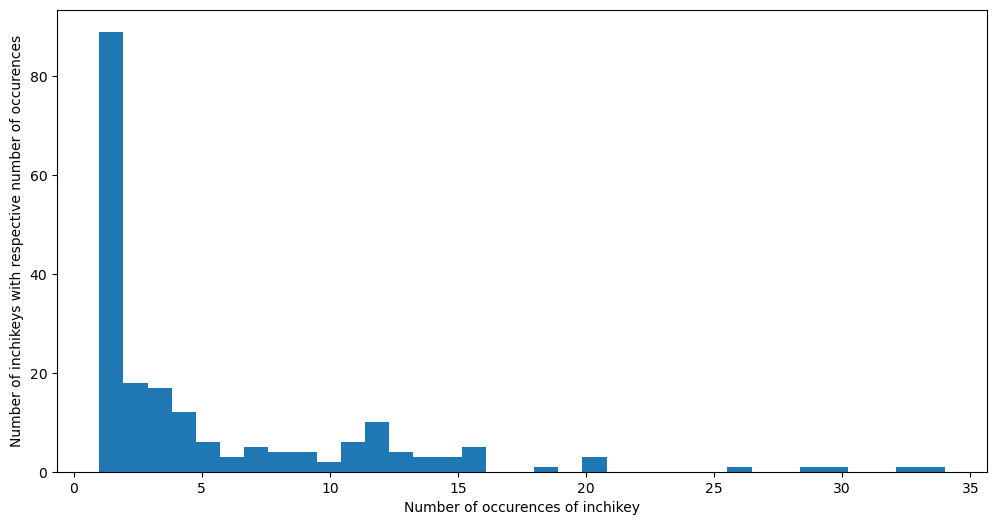

In [246]:
plt.figure(figsize=(12,6))
plt.hist(inchikeys_pd.str[:14][selected_spectra].value_counts(), 35)
plt.xlabel('Number of occurences of inchikey')
plt.ylabel('Number of inchikeys with respective number of occurences')

## Train new model on AllPositive dataset WITHOUT selected spectra

In [24]:
from spec2vec import Spec2VecParallel
from spec2vec import SpectrumDocument

In [247]:
documents_library = [SpectrumDocument(s, n_decimals=2) for i, s in enumerate(spectrums_s2v) if i not in selected_spectra]

In [248]:
len(documents_library), len(spectrums_s2v)

(94290, 95320)

In [250]:
from spec2vec.model_building import train_new_word2vec_model

path_models = os.path.join(path_data, "trained_models")
model_file = os.path.join(path_models, "spec2vec_unknown_compound_matching.model")

iterations = [1, 3, 5, 10, 15, 20]

# Train model with default parameters
model = train_new_word2vec_model(documents_library, iterations, model_file)

  Epoch 1 of 20.Change in loss after epoch 1: 5628790.5
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\matchms\data\trained_models\spec2vec_unknown_compound_matching_iter_1.model
  Epoch 2 of 20.Change in loss after epoch 2: 4332522.5
  Epoch 3 of 20.Change in loss after epoch 3: 3885474.0
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\matchms\data\trained_models\spec2vec_unknown_compound_matching_iter_3.model
  Epoch 4 of 20.Change in loss after epoch 4: 3564895.0
  Epoch 5 of 20.Change in loss after epoch 5: 2904324.0
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\matchms\data\trained_models\spec2vec_unknown_compound_matching_iter_5.model
  Epoch 6 of 20.Change in loss after epoch 6: 2789902.0
  Epoch 7 of 20.Change in loss after epoch 7: 2706990.0
  Epoch 8 of 20.Change in loss after epoch 8: 2632880.0
  Epoch 9 of 20.Change in loss after epoch 9: 25

## Actual library matching

In [29]:
sys.path.insert(0, os.path.join(ROOT, "custom_functions"))

In [30]:
from library_search import library_matching

#### Load word2vec model

In [251]:
path_models = os.path.join(path_data, "trained_models")
model_file = os.path.join(path_models, "spec2vec_unknown_compound_matching_iter_15.model")
model = gensim.models.Word2Vec.load(model_file)

In [249]:
documents_query = [SpectrumDocument(spectrums_s2v[i], n_decimals=2) for i in selected_spectra]

In [252]:
len(documents_query)

1030

In [253]:
documents_query[0]._obj.get("inchikey")

'USEXQPWLCGBYNT-UHFFFAOYSA-N'

### Correct a few (< 10) spectrums with missing precursor_mz

In [35]:
for i, spec in enumerate(spectrums_s2v):
    if not spec.get("precursor_mz"):
        print(i)
        fix_mass = 0.0
        for history in spec.metadata['annotation_history']:
            fix_mass_test = float(history['Precursor_MZ'])
            fix_mass = max(fix_mass, fix_mass_test)
        charge = spec.get("charge")
        protons_mass = 1.00727645199076 * charge
        precursor_mass = fix_mass * abs(charge)
        parent_mass = precursor_mass - protons_mass
        if parent_mass:
            print("parent mass new:", parent_mass, "former was:", spec.get("parent_mass"))
            spec.set("parent_mass", parent_mass)
        print("precursor_mz new:", fix_mass, "former was:", spec.get("precursor_mz"))
        spec.set("precursor_mz", fix_mass)

2765
parent mass new: 547.2247235480093 former was: -1.00727645199076
precursor_mz new: 548.232 former was: 0.0
2766
parent mass new: 589.2357235480093 former was: -1.00727645199076
precursor_mz new: 590.243 former was: 0.0
3942
parent mass new: 466.2697235480092 former was: -1.00727645199076
precursor_mz new: 467.277 former was: 0.0
3974
parent mass new: 674.4887235480093 former was: -1.00727645199076
precursor_mz new: 675.496 former was: 0.0
3975
parent mass new: 691.5147235480093 former was: -1.00727645199076
precursor_mz new: 692.522 former was: 0.0
3976
parent mass new: 696.4707235480092 former was: -1.00727645199076
precursor_mz new: 697.478 former was: 0.0
3983
parent mass new: 629.6107235480093 former was: -1.00727645199076
precursor_mz new: 630.618 former was: 0.0
3984
parent mass new: 491.47072354800923 former was: -1.00727645199076
precursor_mz new: 492.478 former was: 0.0
3985
parent mass new: 531.4627235480093 former was: -1.00727645199076
precursor_mz new: 532.47 former w

### Run Spec2Vec and parentmass based library matching for 1030 against 94290 spectra

In [254]:
found_matches = library_matching(documents_query, documents_library,
                                 model,
                                 presearch_based_on=["parentmass", "spec2vec-top10"],
                                 ignore_non_annotated=True,
                                 intensity_weighting_power=0.5,
                                 allowed_missing_percentage=10.0,
                                 cosine_tol=0.005,
                                 mass_tolerance=1.0)

Pre-selection includes spec2vec top 10.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.23%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.16%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.19%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.25%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.21%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.46%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 7.93%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.56%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.42%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.12%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.21%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.28%.


In [255]:
len(found_matches)

1030

In [256]:
found_matches[104].sort_values(by=["s2v_score"], ascending=False)

,mass_match,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,s2v_score
13580,0.0,0.959048,19,0.959048,19,0.894109
14776,0.0,0.943371,17,0.943371,17,0.840442
14958,0.0,0.954251,15,0.954251,15,0.836036
14959,0.0,0.962202,20,0.962206,21,0.828903
77774,0.0,0.946057,15,0.946057,15,0.824891
...,...,...,...,...,...,...
69128,1.0,0.000000,0,0.000000,0,-0.064105
37978,1.0,0.000000,0,0.000000,0,-0.083420
15254,1.0,0.000000,0,0.000000,0,-0.091607
69091,1.0,0.000000,0,0.000000,0,-0.093683


## Collect all top-10 matches based on Spec2Vec similarity

In [87]:
from matchms.utils import derive_fingerprint_from_inchi
from matchms.utils import derive_fingerprint_from_smiles

def get_mol_fingerprints(spectrums, fingerprint_type="daylight", nbits=2048):
    """Return molecular finterprints.
    """
    def _get_fingerprint_from_spectrum(spectrum):
        # First try to get fingerprint from smiles
        if spectrum is None:
            return None
        if spectrum.get("smiles", None):
            fingerprint = derive_fingerprint_from_smiles(spectrum.get("smiles"),
                                                         fingerprint_type, nbits)
            if isinstance(fingerprint, np.ndarray) and fingerprint.sum() > 0:
                return fingerprint

        # Second try to get fingerprint from inchi
        if spectrum.get("inchi", None):
            fingerprint = derive_fingerprint_from_inchi(spectrum.get("inchi"),
                                                        fingerprint_type, nbits)
            if isinstance(fingerprint, np.ndarray) and fingerprint.sum() > 0:
                return fingerprint  
        
    fingerprints = []
    for spec in spectrums:
        fingerprint = _get_fingerprint_from_spectrum(spec)
        #if fingerprint is None:
         #   fingerprint = np.zeros((nbits))
        #    print("No fingerprint generated for spectrum with id: {}".format(spec.get("spectrumid")))
        fingerprints.append(fingerprint)
    
    return fingerprints

In [44]:
ID = 0
found_matches[ID].sort_values(by=["s2v_score"], ascending=False).index.tolist()[:10]

[46717, 41024, 32769, 45911, 33221, 48440, 51438, 32335, 49728, 34072]

In [61]:
fingerprint_query

[None]

In [70]:
jaccard_similarity_matrix(np.asarray(fingerprint_query), np.asarray(fingerprint_matches))

array([[1.        , 1.        , 1.        , 0.94736842, 1.        ,
        0.94736842, 1.        , 0.94736842, 1.        , 0.94736842]])

In [257]:
from matchms.similarity.vector_similarity_functions import jaccard_similarity_matrix

mol_sim_matches = []
list_sv2 = []
list_modcos = []
list_copies = []

for ID in range(len(documents_query)):
    idx = found_matches[ID].sort_values(by=["s2v_score"], ascending=False).index.tolist()[:10]

    #match_IDs = found_matches[ID].loc[idx]['spectra_ID'].values.tolist()
    
    if len(idx) > 0:
        fingerprint_query = get_mol_fingerprints([documents_query[ID]._obj], 
                                                     fingerprint_type="daylight", #morgan3", 
                                                     nbits=2048)
        fingerprint_matches = get_mol_fingerprints([documents_library[i]._obj for i in idx], 
                                                     fingerprint_type="daylight", #morgan3",  
                                                     nbits=2048)

        # calculate similarities
        if fingerprint_query[0] is None:
            print("No fingerprint generated for query spectrum {}".format(ID))
        else:
            if np.sum([1 for x in fingerprint_matches if x is None]) > 0:
                print("Found {} not generated fingerprints in matches".format(np.sum([1 for x in fingerprint_matches if x is None])))
            exclude_empty_fps = [i for i, x in enumerate(fingerprint_matches) if x is not None]
            if len(fingerprint_matches) > 0 and len(fingerprint_query) > 0:
                Mtest = jaccard_similarity_matrix(np.asarray(fingerprint_query),
                                                   np.asarray([fingerprint_matches[i] for i in exclude_empty_fps]))
                mol_sim_matches.append(Mtest)
            else:
                mol_sim_matches.append(None)

            list_sv2.append(found_matches[ID].loc[[idx[i] for i in exclude_empty_fps]]['s2v_score'].values.tolist())
            list_modcos.append(found_matches[ID].loc[[idx[i] for i in exclude_empty_fps]]['mod_cosine_score'].values.tolist())
            #list_copies.append(found_matches[ID].loc[idx]['inchikey_copies'].values.tolist())

Found 1 not generated fingerprints in matches
Found 1 not generated fingerprints in matches
Found 1 not generated fingerprints in matches


In [258]:
len(mol_sim_matches)

1030

In [118]:
def histogram_found_matches(matches,
                            n_bins,
                            method = "ideal_pick",
                            sort_by_lst = None,
                            filename = None):
    """ Create histogram and plot it.
    """
    bins_lst = np.linspace(0,1,n_bins+1) 
    plt.style.use('default') #('ggplot')
    plt.figure(figsize=(8,7))
    
    nums = len(matches)
    if method == "ideal_pick": 
        # Chose best pick from condidate suggestions
        #hist, bin_edges = np.histogram(np.max(matches, axis=2), bins_lst)
        pick = []
        for i in range(nums):
            pick += [np.array(matches[i]).argmax()]
        hist, bin_edges = np.histogram(np.array([matches[i][0][pick[i]] for i in range(nums)]), bins_lst)
    elif method == 'argmax':
        if sort_by_lst is None:
            print("sort_by_lst list expected.")
        pick = []
        for i in range(nums):
            pick += [np.array(sort_by_lst[i]).argmax()]
        hist, bin_edges = np.histogram(np.array([matches[i][0][pick[i]] for i in range(nums)]), bins_lst)
    
    bar_width = 0.8 * 1/n_bins
    plt.bar(bin_edges[:-1], 100*hist/np.sum(hist), width = bar_width, color='none', edgecolor='gray', hatch="///", lw=2., zorder = 0)
    plt.bar(bin_edges[:-1], 100*hist/np.sum(hist), width = bar_width, edgecolor='black', linewidth=3, color='none',alpha=1)
    #plt.xlabel('best found molecular similarity among Spec2Vec top-10 suggestions \n (rdkit-2048 fingerprint --> jaccard score)')
    maxbar = np.max(100*hist/np.sum(hist))
    plt.yticks(10*np.arange(np.ceil(maxbar/10)), ["{}".format(10*x) for x in np.arange(np.ceil(maxbar/10))], fontsize=12)
    
    bar_labels = ['{:03.1f} - {:03.1f}'.format(bins_lst[i], bins_lst[i+1]) for i in range(n_bins)]
    plt.xticks(bins_lst[:-1], bar_labels, fontsize=12, rotation='vertical')
    plt.xlabel('molecular similarity (Tanimoto)', fontsize=16)
    plt.ylabel('fraction of matches [%]', fontsize=16)
    
    if filename is not None:
        plt.savefig(filename)
        
    return hist, bin_edges

[190 221 175  96 348]


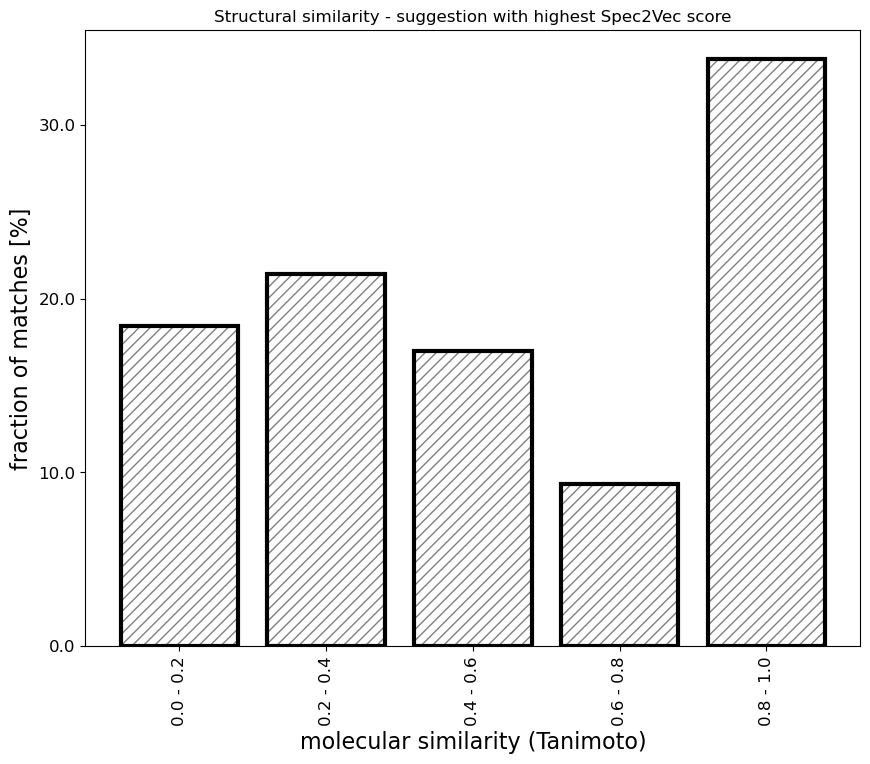

In [259]:
hist, bin_edges = histogram_found_matches(mol_sim_matches, 
                                          5,
                                           'argmax',
                                           list_modcos)
print(hist)
plt.title("Structural similarity - suggestion with highest Spec2Vec score")
plt.savefig("unknown_compound_matching_s2v_argmax.pdf", bbox_inches='tight')

[ 51 152 199 141 487]


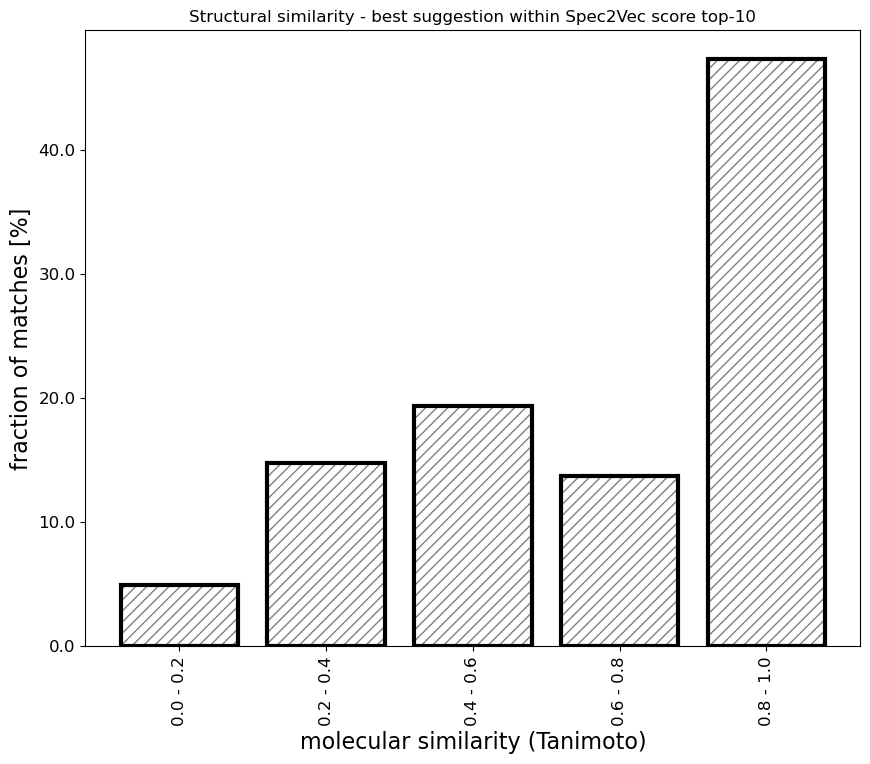

In [260]:
hist, bin_edges = histogram_found_matches(mol_sim_matches, 
                                          5,
                                           'ideal_pick',
                                           list_modcos)
print(hist)

plt.title("Structural similarity - best suggestion within Spec2Vec score top-10")
plt.savefig("unknown_compound_matching_s2v_ideal_pick.pdf", bbox_inches='tight')
plt.savefig("unknown_compound_matching_s2v_ideal_pick.png", bbox_inches='tight')

## Inspect some suggestions

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

In [317]:
ID = 80  # query number
threshold = 0.3
top_10_idx = found_matches[ID][found_matches[ID]['s2v_score'] > threshold].sort_values(by=["s2v_score"], ascending=False).index.tolist()[:10]

scores_sorted = found_matches[ID].sort_values(by=["s2v_score"], ascending=False)["s2v_score"].values
molecules = []
s2v_scores = []
for i, idx in enumerate(top_10_idx):
    
    molecules.append(Chem.MolFromSmiles(documents_library[idx]._obj.get("smiles")))  
    s2v_scores.append(scores_sorted[i])
    print(documents_library[idx]._obj.get("smiles"))
    print(documents_library[idx]._obj.get("inchikey"))

print("\n ---------- Query molecule ----------")
print(documents_query[ID]._obj.get("smiles"))
print(documents_query[ID]._obj.get("inchikey"))

Chem.MolFromSmiles(documents_query[ID]._obj.get("smiles"))

CCC(C)C1NC(=O)C2CCCN2C(=O)C(CC(C)C)OC(=O)CCNC(=O)C(C)N(C)C(=O)C(C(C)C)N(C)C1=O
GNBHVMBELHWUIF-UHFFFAOYSA-N
CCC(C)C1NC(=O)C2C(C)CCN2C(=O)C(CC(O)CO)OC(=O)CCNC(=O)C(C)N(C)C(=O)C(C(C)C)N(C)C1=O
FFVWTCUZUPVJAB-UHFFFAOYSA-N
CCC(C)C1NC(=O)C2CCCN2C(=O)C(CC(O)CO)OC(=O)CCNC(=O)C(C)N(C)C(=O)C(C(C)C)N(C)C1=O
DJYDCIUMNXZSBH-UHFFFAOYSA-N
[H]N1C(=O)C([H])(N(C(=O)C([H])(N(C(=O)C([H])(N([H])C(=O)[C@@]2([H])N(C(=O)[C@]([H])(OC(=O)C([H])([H])C1([H])[H])C([H])([H])C1([H])OC1([H])[H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])C([H])(C([H])([H])[H])C([H])([H])C([H])([H])[H])C([H])([H])[H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])[H])C([H])([H])[H]
ZYTHYMZQQBWDDS-LSGBTAIHSA-N
CCC(C)[C@@H]1C(=O)N([C@@H](C(=O)N([C@@H](C(=O)NCCC(=O)OC(C(=O)N2CCC[C@H]2C(=O)N1)CC(CCl)O)C)C)C(C)C)C
WUTLOXOGFQPKLT-XWKBWMEZSA-N
CCC(C)C1NC(=O)C2CCCN2C(=O)C(CC(O)CO)OC(=O)CCNC(=O)C(C)N(C)C(=O)C(C(C)C)N(C)C1=O
DJYDCIUMNXZSBH-UHFFFAOYSA-N
[H]OC(=O)C([H])(C([H])([H])[H])C([H])([H])[C@@]1([H])OC(=O)C([H])([H])C([H])([H])N([H])C(=O)


 ---------- Suggested molecule ----------


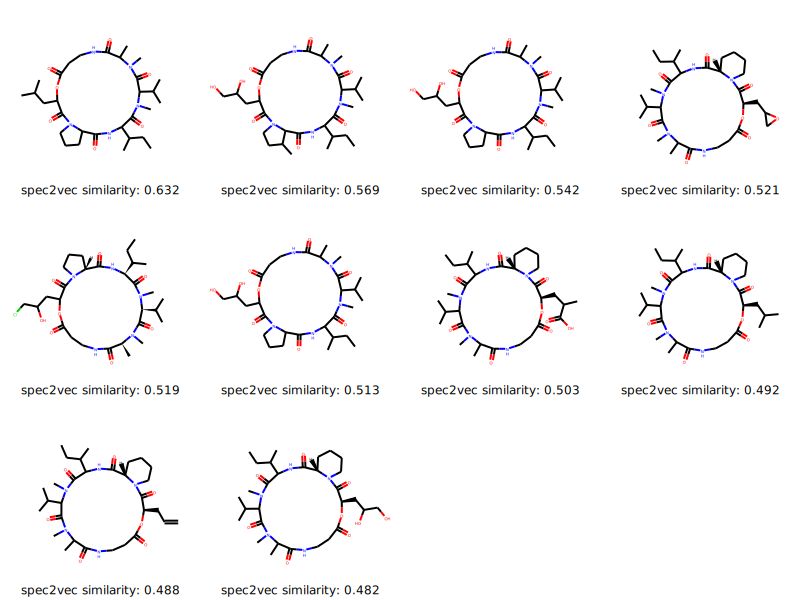

In [318]:
print("\n ---------- Suggested molecule ----------")
Draw.MolsToGridImage([x for x in molecules if x is not None], molsPerRow=4, subImgSize=(200, 200),
                     legends=["spec2vec similarity: {:.3}".format(x) for x in s2v_scores])

In [315]:
ID = 610  # query number
threshold = 0.3
top_10_idx = found_matches[ID][found_matches[ID]['s2v_score'] > threshold].sort_values(by=["s2v_score"], ascending=False).index.tolist()[:10]

scores_sorted = found_matches[ID].sort_values(by=["s2v_score"], ascending=False)["s2v_score"].values
molecules = []
s2v_scores = []
for i, idx in enumerate(top_10_idx):
    
    molecules.append(Chem.MolFromSmiles(documents_library[idx]._obj.get("smiles")))  
    s2v_scores.append(scores_sorted[i])
    print(documents_library[idx]._obj.get("smiles"))
    print(documents_library[idx]._obj.get("inchikey"))

print("\n ---------- Query molecule ----------")
print(documents_query[ID]._obj.get("smiles"))
print(documents_query[ID]._obj.get("inchikey"))

Chem.MolFromSmiles(documents_query[ID]._obj.get("smiles"))

c1(nc(nc(n1)OC)NCC)NC(CC)C
ZJMZZNVGNSWOOM-UHFFFAOYSA-N
c1(nc(nc(n1)OC)NCC)NC(CC)C
ZJMZZNVGNSWOOM-UHFFFAOYSA-N
c1(nc(nc(n1)OC)NCC)NC(CC)C
ZJMZZNVGNSWOOM-UHFFFAOYSA-N
c1(nc(nc(n1)OC)NCC)NC(CC)C
ZJMZZNVGNSWOOM-UHFFFAOYSA-N
c1(nc(nc(n1)OC)NCC)NC(CC)C
ZJMZZNVGNSWOOM-UHFFFAOYSA-N
CCC(C)NC1=NC(=NC(=N1)NCC)OC
ZJMZZNVGNSWOOM-UHFFFAOYSA-N
c1(nc(nc(n1)OC)NCC)NC(CC)C
ZJMZZNVGNSWOOM-UHFFFAOYSA-N
c1(nc(nc(n1)OC)NCC)NC(CC)C
ZJMZZNVGNSWOOM-UHFFFAOYSA-N
c1(nc(nc(n1)OC)NCC)NC(CC)C
ZJMZZNVGNSWOOM-UHFFFAOYSA-N
CCC(C)NC1=NC(=NC(=N1)NCC)OC
ZJMZZNVGNSWOOM-UHFFFAOYSA-N

 ---------- Query molecule ----------
c1(nc(nc(n1)OC)NCC)NC(C)(C)C
BCQMBFHBDZVHKU-UHFFFAOYSA-N



 ---------- Suggested molecule ----------


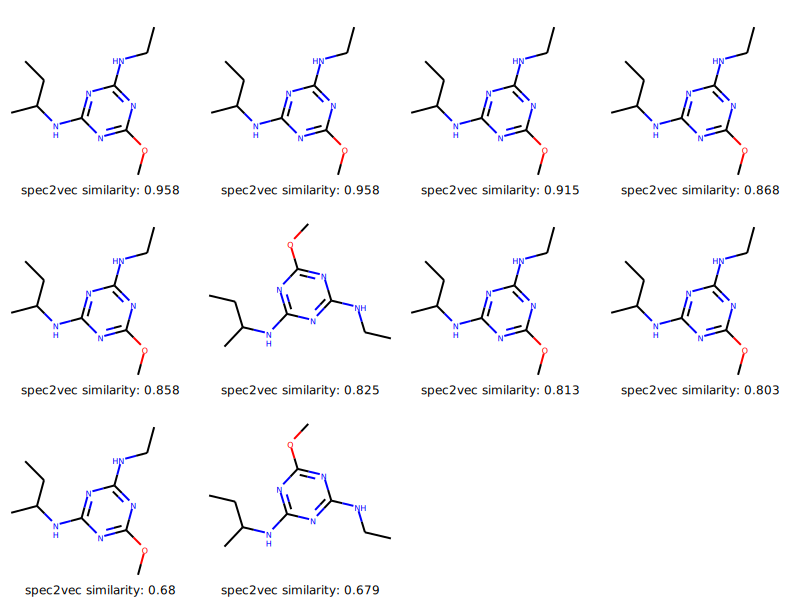

In [316]:
print("\n ---------- Suggested molecule ----------")
Draw.MolsToGridImage([x for x in molecules if x is not None], molsPerRow=4, subImgSize=(200, 200),
                     legends=["spec2vec similarity: {:.3}".format(x) for x in s2v_scores])

In [309]:
ID = 700  # query number
threshold = 0.3
top_10_idx = found_matches[ID][found_matches[ID]['s2v_score'] > threshold].sort_values(by=["s2v_score"], ascending=False).index.tolist()[:10]

scores_sorted = found_matches[ID].sort_values(by=["s2v_score"], ascending=False)["s2v_score"].values
molecules = []
s2v_scores = []
for i, idx in enumerate(top_10_idx):
    
    molecules.append(Chem.MolFromSmiles(documents_library[idx]._obj.get("smiles")))  
    s2v_scores.append(scores_sorted[i])
    print(documents_library[idx]._obj.get("smiles"))
    print(documents_library[idx]._obj.get("inchikey"))

print("\n ---------- Query molecule ----------")
print(documents_query[ID]._obj.get("smiles"))
print(documents_query[ID]._obj.get("inchikey"))

Chem.MolFromSmiles(documents_query[ID]._obj.get("smiles"))

CC(C)(O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O)C(OC(=O)/C=C/c1ccc(O)cc1)C(=O)OCc1ccc(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)cc1
LZXXRASHAINSDN-XEHIIEKUSA-N
CC(C)(O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O)C(OC(=O)/C=C/c1ccc(O)cc1)C(=O)OCc1ccc(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)cc1
LZXXRASHAINSDN-XEHIIEKUSA-N
CC(C)(O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O)C(OC(=O)/C=C/c1ccc(O)cc1)C(=O)OCc1ccc(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)cc1
LZXXRASHAINSDN-XEHIIEKUSA-N
CC(C)(O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O)C(OC(=O)/C=C/c1ccc(O)cc1)C(=O)OCc1ccc(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)cc1
LZXXRASHAINSDN-XEHIIEKUSA-N
CC(C)(O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O)C(OC(=O)/C=C/c1ccc(O)cc1)C(=O)OCc1ccc(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)cc1
LZXXRASHAINSDN-XEHIIEKUSA-N
CC(C)(O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O)C(OC(=O)\C=C/C2=CC=C(O)C=C2)C(=O)OCC3=CC=C(O[C@@H]4O[C@H](CO)[C@@H](O)[C@H](O)[C@H]4O)C=C3
LZXXRASHAINSDN-ZLFKWPTHSA-N
CC(C)(O[C@@H]1O[C@H](C


 ---------- Suggested molecule ----------


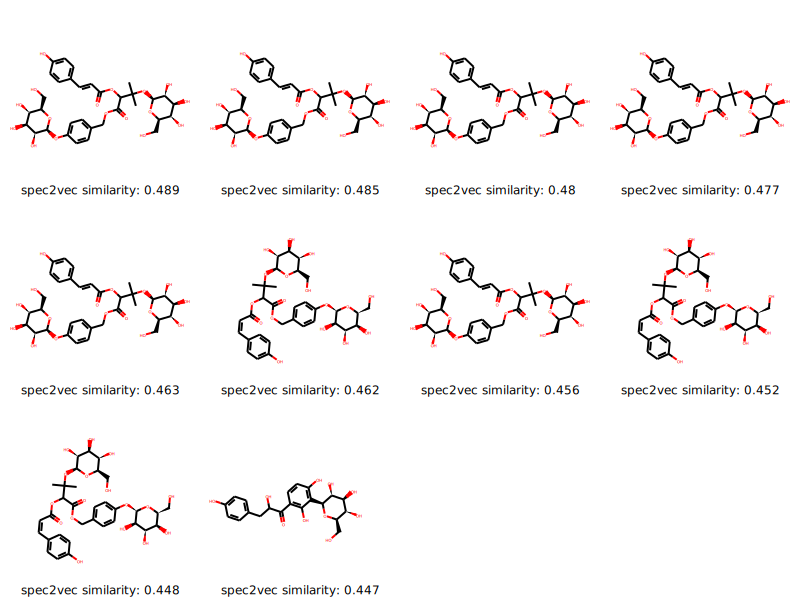

In [310]:
print("\n ---------- Suggested molecule ----------")
Draw.MolsToGridImage([x for x in molecules if x is not None], molsPerRow=4, subImgSize=(200, 200),
                     legends=["spec2vec similarity: {:.3}".format(x) for x in s2v_scores])

In [322]:
ID = 850  # query number
threshold = 0.4
top_10_idx = found_matches[ID][found_matches[ID]['s2v_score'] > threshold].sort_values(by=["s2v_score"], ascending=False).index.tolist()[:10]

scores_sorted = found_matches[ID].sort_values(by=["s2v_score"], ascending=False)["s2v_score"].values
molecules = []
s2v_scores = []
for i, idx in enumerate(top_10_idx):
    
    molecules.append(Chem.MolFromSmiles(documents_library[idx]._obj.get("smiles")))  
    s2v_scores.append(scores_sorted[i])
    print(documents_library[idx]._obj.get("smiles"))
    print(documents_library[idx]._obj.get("inchikey"))

print("\n ---------- Query molecule ----------")
print(documents_query[ID]._obj.get("smiles"))
print(documents_query[ID]._obj.get("inchikey"))

Chem.MolFromSmiles(documents_query[ID]._obj.get("smiles"))

C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@@H]3[C@H](O)[C@H](O)[C@@H]4C[C@H](O)CC[C@]4(C)[C@H]3C[C@H](O)[C@@]21C
COCMFMBNEAMQMA-NQTCFNIESA-N
C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](C[C@H](O)[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1[C@H](O)[C@@H]3O
COCMFMBNEAMQMA-KREOYVNCSA-N
C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](C[C@H](O)[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1[C@H](O)[C@@H]3O
COCMFMBNEAMQMA-KREOYVNCSA-N
C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](C[C@H](O)[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1[C@H](O)[C@@H]3O
COCMFMBNEAMQMA-KREOYVNCSA-N
C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](C[C@H](O)[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1[C@H](O)[C@@H]3O
COCMFMBNEAMQMA-KREOYVNCSA-N
C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](C[C@H](O)[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@@H]1[C@H](O)[C@@H]3O
COCMFMBNEAMQMA-ZGZKPZGFSA-N
C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](C[C@H](O)[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@@H]1[C@@H](O)[C@@H]3O
COCMFMBNEAMQMA-OGAWIUPOSA-N
C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](C[C@H](O)[C@@]21C)[C@@]1(C)CC[C@


 ---------- Suggested molecule ----------


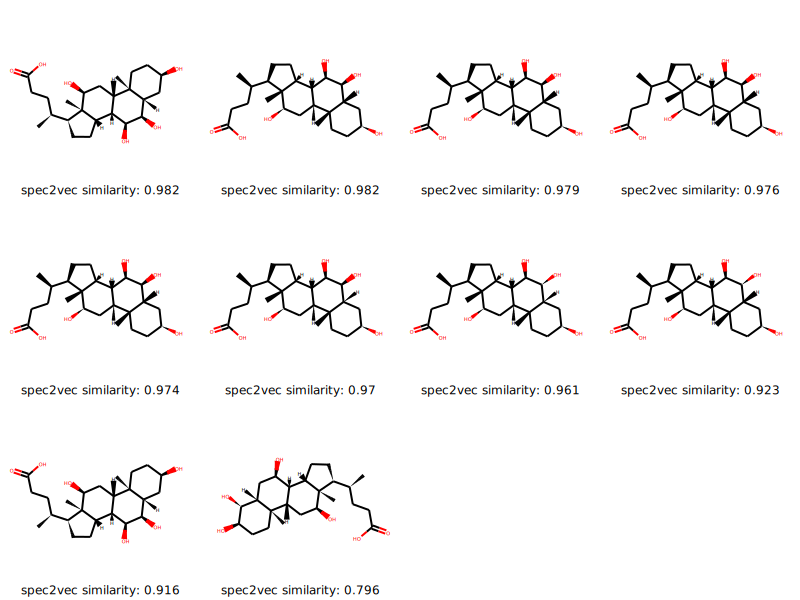

In [323]:
print("\n ---------- Suggested molecule ----------")
Draw.MolsToGridImage([x for x in molecules if x is not None], molsPerRow=4, subImgSize=(200, 200),
                     legends=["spec2vec similarity: {:.3}".format(x) for x in s2v_scores])

## Examples where it "fails"

In [324]:
ID = 0  # query number
threshold = 0.4
top_10_idx = found_matches[ID][found_matches[ID]['s2v_score'] > threshold].sort_values(by=["s2v_score"], ascending=False).index.tolist()[:10]

scores_sorted = found_matches[ID].sort_values(by=["s2v_score"], ascending=False)["s2v_score"].values
molecules = []
s2v_scores = []
for i, idx in enumerate(top_10_idx):
    
    molecules.append(Chem.MolFromSmiles(documents_library[idx]._obj.get("smiles")))  
    s2v_scores.append(scores_sorted[i])
    print(documents_library[idx]._obj.get("smiles"))
    print(documents_library[idx]._obj.get("inchikey"))

print("\n ---------- Query molecule ----------")
print(documents_query[ID]._obj.get("smiles"))
print(documents_query[ID]._obj.get("inchikey"))

Chem.MolFromSmiles(documents_query[ID]._obj.get("smiles"))

COc1c2ccoc2cc2oc(C)cc(=O)c12
NZVQLVGOZRELTG-UHFFFAOYSA-N
COc1cc2oc3c(Cl)c(OC)cc(C)c3c(=O)c2c(OC)c1Cl
QCVBBEYCXWJERE-UHFFFAOYSA-N
COc1cc(-c2ccc(N)c(OC)c2)ccc1N
JRBJSXQPQWSCCF-UHFFFAOYSA-N
COc1cc(-c2ccc(N)c(OC)c2)ccc1N
JRBJSXQPQWSCCF-UHFFFAOYSA-N
COc1c2ccoc2cc2oc(C)cc(=O)c12
NZVQLVGOZRELTG-UHFFFAOYSA-N
COC1=C2C=CC(=O)OC2=CC3=C1C=CO3
BGEBZHIAGXMEMV-UHFFFAOYSA-N
COc1ccc(-c2oc3cc4c(c(OC)c3c(=O)c2OC)OCO4)cc1
LWUQVHKGVXRUPD-UHFFFAOYSA-N
COC1=C2C=CC(=O)OC2=CC3=C1C=CO3
BGEBZHIAGXMEMV-UHFFFAOYSA-N
CSc1nc2ccccc2s1
UTBVIMLZIRIFFR-UHFFFAOYSA-N
CSc1nc2cc(Oc3cccc(Cl)c3Cl)c(Cl)cc2[nH]1
NQPDXQQQCQDHHW-UHFFFAOYSA-N

 ---------- Query molecule ----------
CN(C)C1=CC(Br)=CC=C1
USEXQPWLCGBYNT-UHFFFAOYSA-N



 ---------- Suggested molecule ----------


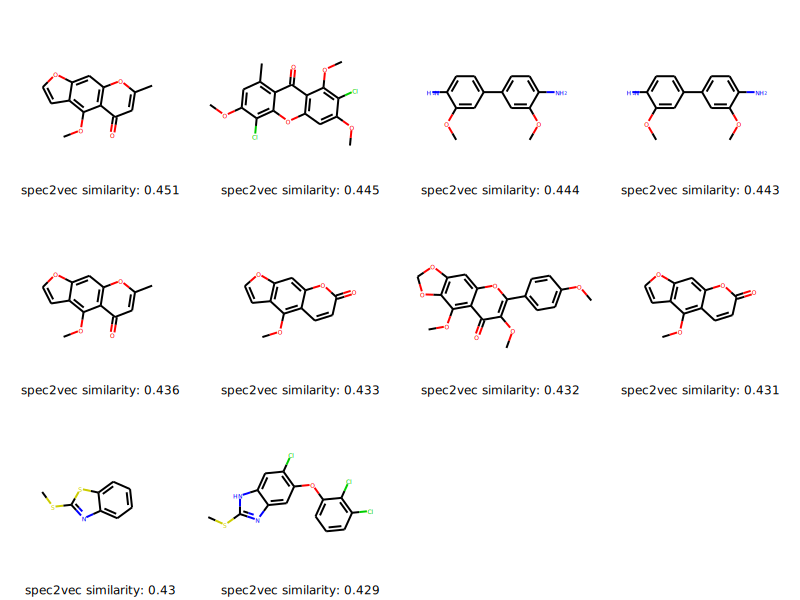

In [325]:
print("\n ---------- Suggested molecule ----------")
Draw.MolsToGridImage([x for x in molecules if x is not None], molsPerRow=4, subImgSize=(200, 200),
                     legends=["spec2vec similarity: {:.3}".format(x) for x in s2v_scores])

## Ideas
+ I suspect that small molecules will lead to worse results

In [332]:
# Check why...
print(documents_query[ID]._obj.get("precursor_mz"))
print("number of 'words' {}".format(len(documents_query[ID].words)))

200.007
number of 'words' 21


In [334]:
n_words = []
masses = []
for doc in documents_query:
    n_words.append(len(doc.words))
    masses.append(doc._obj.get("precursor_mz"))

In [345]:
mol_sim_matches[610], len(n_words)

(array([[0.86195286, 0.86195286, 0.86195286, 0.86195286, 0.86195286,
         0.86195286, 0.86195286, 0.86195286, 0.86195286, 0.86195286]]),
 1030)

In [349]:
ref_scores = np.asarray([x[0] for x in mol_sim_matches])
ref_scores.shape

(1030,)

In [353]:
np.asarray(n_words)

array([21, 21, 20, ..., 24, 26, 20])

In [355]:
np.asarray([x[0][0] for x in mol_sim_matches])

array([0.07722008, 0.07722008, 0.04632153, ..., 0.67624021, 0.67624021,
       0.67624021])

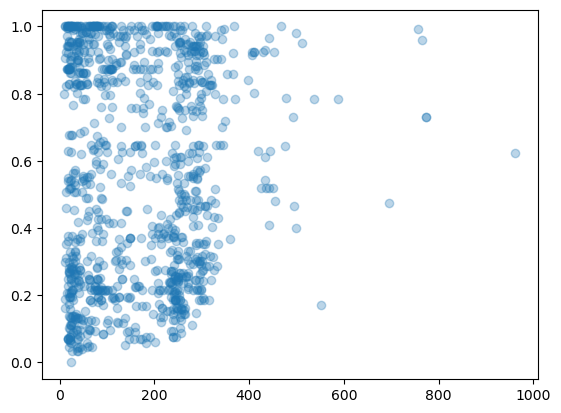

In [357]:
plt.scatter(np.asarray(n_words), np.asarray([x[0][0] for x in mol_sim_matches]), alpha=0.3)

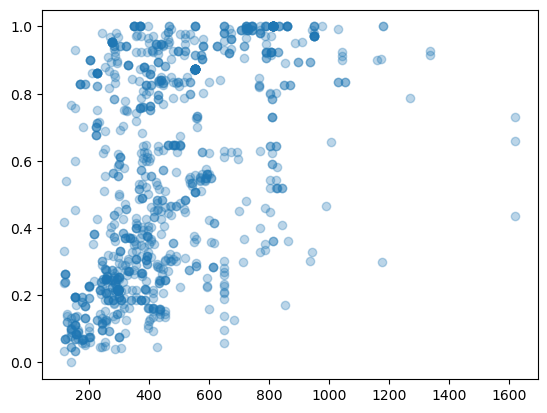

In [358]:
plt.scatter(np.asarray(masses), np.asarray([x[0][0] for x in mol_sim_matches]), alpha=0.3)